JJJ

In [28]:
#Settings relative to .ipynb file format that have to be executed here

#Make reloading of modules automatic et évite d'avoir à redémarer le kernel et tout re executer pour appliquer la modification d'un module dans __main__.
%load_ext autoreload  
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
#src.useful_functions
import sys
sys.path.append('../src')  # Adjust the path to import modules in src/



from data import make_dataset
from data import preprocessing
from visualization import visualize
import user_test
from pipeline import model, results
from sklearn.base import clone

Beginning of the test

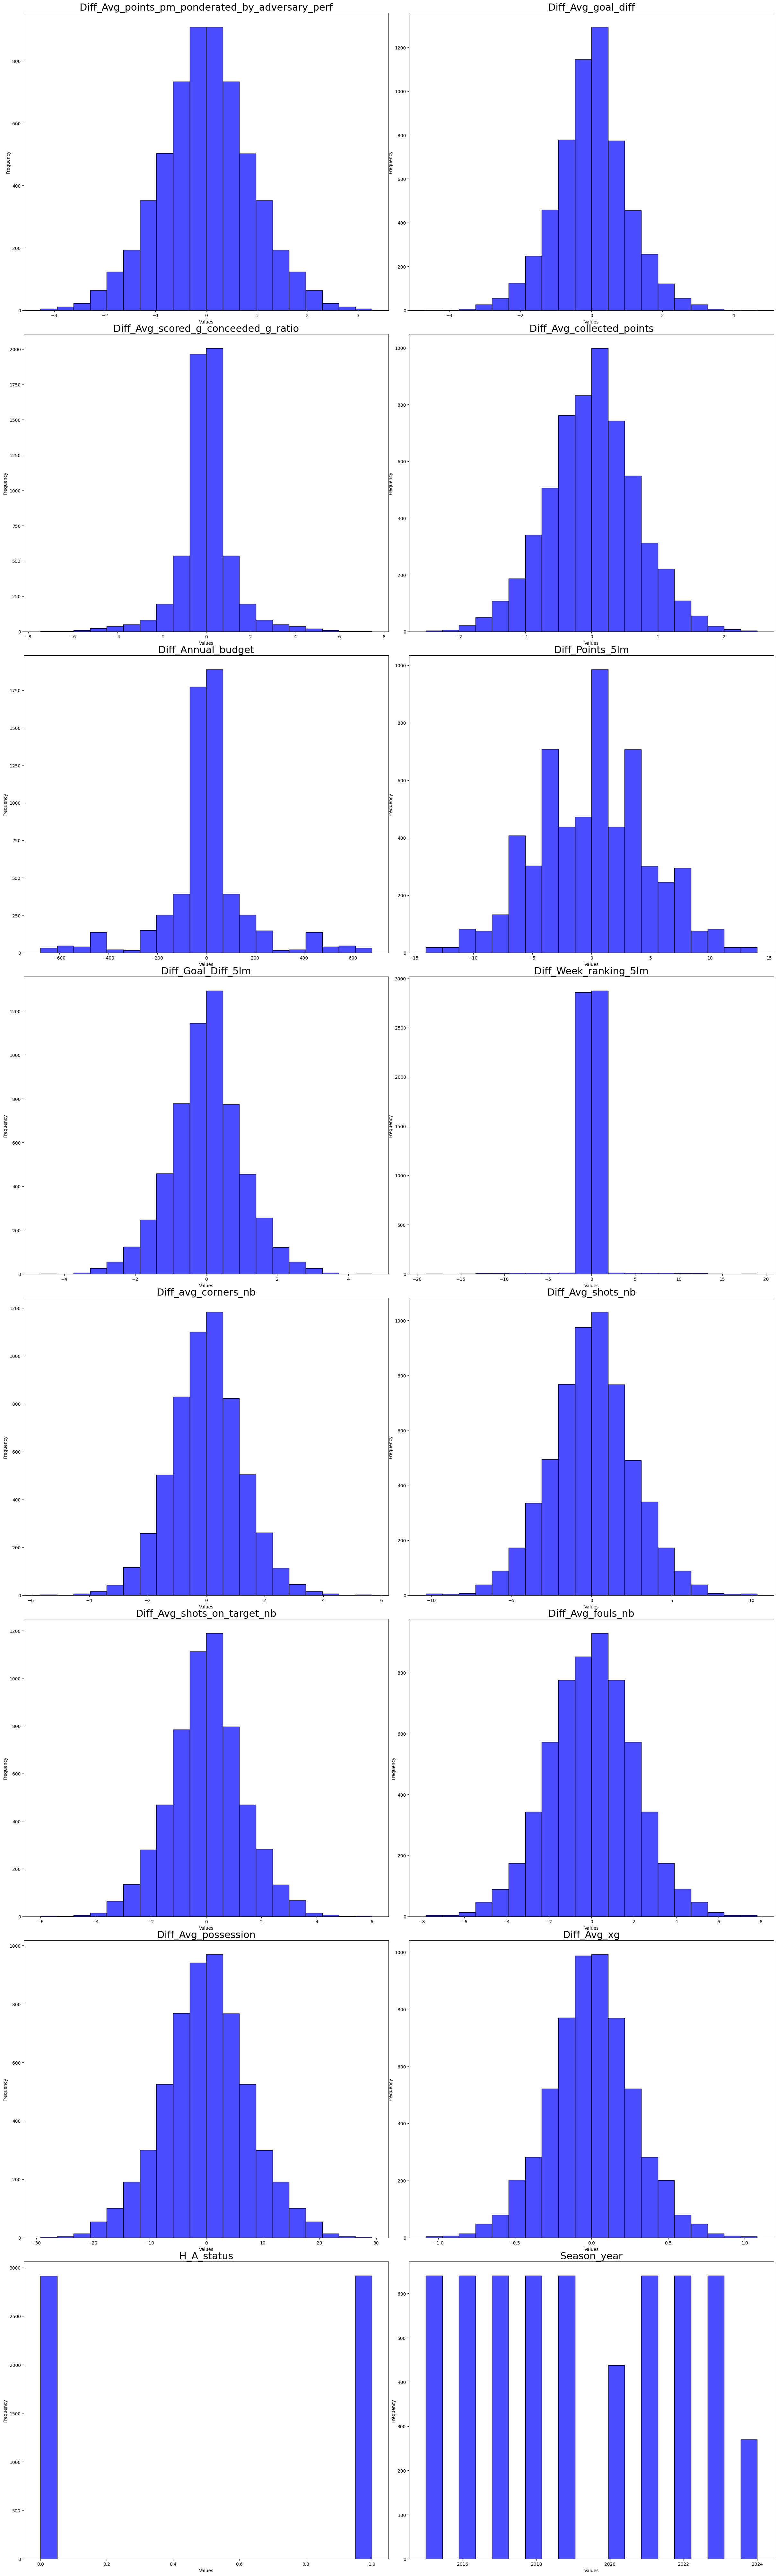

In [30]:
#Importation of the fotball data
X   = make_dataset.load_data(False, 'processed/not_split/X')
Y   = make_dataset.load_data(False, 'processed/not_split/Y')
X_info = make_dataset.load_data(False, 'processed/not_split/X_info')


# Short data insight
visualize.plot_all_num_features(X, save = False, density_estimate = False)

- All the features names starts with 'Diff_' as they all are the difference of a given statistic for the two teams which confront.

- The features presented above are the ones kept after a selection among more than 150


We start splitting the dataset with 6 seasons in trainset and 3 in test set.

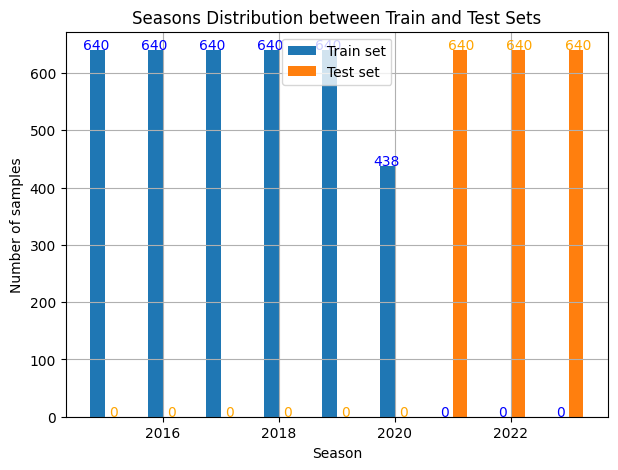

In [31]:
#Load the train and test datasets:
X_train_00   = make_dataset.load_data(False, 'processed/split/X_train_00')
Y_train_00   = make_dataset.load_data(False, 'processed/split/Y_train_00')
X_test_00   = make_dataset.load_data(False, 'processed/split/X_test_00')
Y_test_00   = make_dataset.load_data(False, 'processed/split/Y_test_00')

# Show dataset train and test sets repratition
preprocessing.hist_seasons(X_train_00.copy(), X_test_00.copy())

The shorter bar in 2020 is the covid season which was interupted before the end. We decided not to shuffle samples as in a realistic case we train our model before the begining of the season. We will see below a more sophisticated strategy of training based on weekly or annual model training

<span style="color:#FF8000;"> <strong> <font size="4"> Model definition

In [32]:

# Chose a number of features the selector will select

nb_of_feat_to_select = 15


### Chose Scaler

# RobustScaler 
# StandardScaler
# MinMaxScaler

Scaler = "StandardScaler"


### Chose Logistic Rgression regularization penalty

# l1
# l2
# elasticnet
# None

penalty = 'l1'


### Chose regularization factor

C = 1


# Create the pipeline
personalised_pipeline = user_test.create_pipeline(nb_of_feat_to_select, Scaler, penalty, C)

# Model training
personalised_pipeline.fit(X_train_00.copy(), Y_train_00.copy().values.ravel())


# Just to have an idea of the optimal parameters combination
# Best pipeline developed by myself
best_pipeline = model.load_pipeline("chosen_pipeline")
print(best_pipeline)

Successfully loaded the pipeline: chosen_pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('features_selector', SelectKBest(k=13)),
                ('model',
                 LogisticRegression(C=0.025118864315095808, max_iter=3000,
                                    random_state=999, solver='newton-cg',
                                    verbose=False))])


Perform pipeline prediction on test set

In [38]:
#Make 'normal' proba predictions 
normal_proba_pred = personalised_pipeline.predict_proba(X_test_00)[:,1]

#Make proba predictions retraining the pipeline at every Game Week or every Season:
proba_pred_GW_training, Y_test_GW_training, X_info_GW_training = results.proba_prediction_retrained_each_seas(X, Y, X_info, clone(personalised_pipeline), 'season', test_seasons =[2021,2022,2023])


c:\Users\polol\OneDrive\Documents\ML\Projet Mbappe (11.23- )\Projet Mbappe Cookiestructure\notebooks\../src\pipeline\results.py:489: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_info_pred = pd.concat([X_info_pred, X_test_info_for_this_seas], ignore_index=True, axis=0)


We first perform a classic prediction based on the previously trained pipeline. Below we perform the "sophisticated" method train-test split. We retrain the pipeline at every season before performing prediction for the coming season

Plot pipeline performances

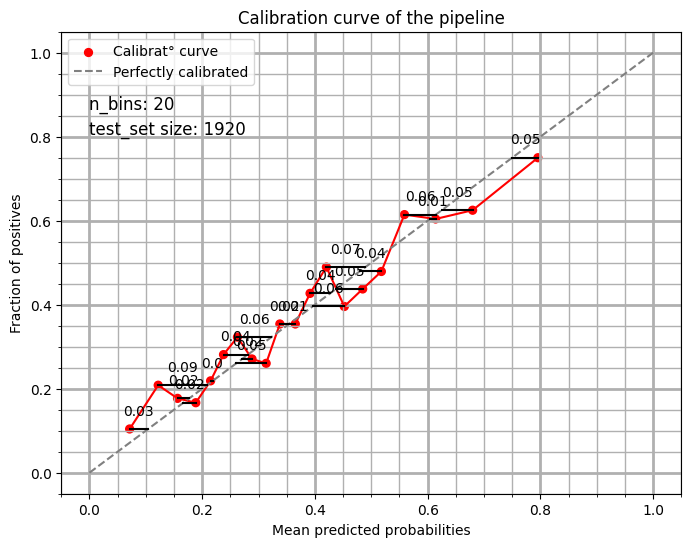

Above learning curve statistics on bins:

╒════╤════════════════╤═════════════════════════════╕
│    │ Bin interval   │   Predictions nb in the bin │
╞════╪════════════════╪═════════════════════════════╡
│  0 │ [0.02, 0.1]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  1 │ [0.1, 0.14]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  2 │ [0.14, 0.17]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  3 │ [0.17, 0.2]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  4 │ [0.2, 0.23]    │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  5 │ [0.23, 0.25]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  6 │ [0.25, 0.27]   │                          96 │
├────┼────────────────┼─────────────────────────────┤
│  7 │ [0.27, 0.3]    │                 

TypeError: print_calibration_stats() missing 1 required positional argument: 'calibrated_or_not'

In [39]:


# We choose wether we plot the graphs on GW training simulations or on 'normal' training simulations

plot_with_annual_training = True


user_test.plot_pipeline_pred_results(proba_pred_GW_training, Y_test_GW_training, X_info_GW_training, normal_proba_pred, plot_with_annual_training)

